# Bag of Visual Words
From https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/ with polished code

In [1]:
from src.phishIRISData import PhishIRISDataset
from src.config import config
from src.helpers import compute_accuracy, visualize

from src.SIFT_bovw import (
    read_bw_images,
    sift_features,
    get_visual_words,
    get_frequency_vectors,
    get_tfidf,
    search_test,
)

import joblib

In [2]:
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

In [3]:
k, codebook = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")

In [4]:
bw_images_train = read_bw_images(train_dataset.img_paths)
bw_images_val = read_bw_images(val_dataset.img_paths)

In [5]:
keypoints_train, descriptors_train = sift_features(bw_images_train)
keypoints_val, descriptors_val = sift_features(bw_images_val)

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_val = get_visual_words(descriptors_val, codebook)

frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_val = get_frequency_vectors(visual_words_val, k)

tfidf_train = get_tfidf(frequency_vectors_train)

len before: 1313
indexes: []
len after: 1313
len before: 1539
indexes: []
len after: 1539
df.shape, df[:5]: (200,), [1187  935 1277 1279 1244]
idf.shape, idf[:5]: (200,), [0.10088548 0.33952335 0.02780102 0.02623607 0.0539826 ]


In [6]:
y_pred = []
y_conf = []
y_true = []

for idx, (X, label) in enumerate(val_dataset):
    indexes, confidence_scores = search_test(
        frequency_vectors_val[idx], tfidf_train, top_k=1
    )
    _, pred_label = train_dataset[indexes[0]]
    y_pred.append(pred_label)
    y_conf.append(confidence_scores[0])
    y_true.append(label)

compute_accuracy(y_true, y_pred)

acc:		48.40806
f1:		53.16467


(0.48408057179987, 0.5316467232243293)

In [7]:
from sklearn.metrics import classification_report
import numpy as np

print(
    classification_report(
        y_true, y_pred, target_names=np.unique([label for _, label in train_dataset])
    )
)

              precision    recall  f1-score   support

       adobe       0.50      0.67      0.57        27
     alibaba       0.21      0.77      0.33        26
      amazon       0.21      0.55      0.30        11
       apple       0.32      0.80      0.46        15
         boa       0.12      0.74      0.21        35
       chase       0.20      0.68      0.31        37
         dhl       0.60      0.71      0.65        42
     dropbox       0.60      0.70      0.64        40
    facebook       0.67      0.61      0.64        57
    linkedin       0.32      0.43      0.36        14
   microsoft       0.86      0.45      0.59        53
       other       0.92      0.40      0.56      1000
      paypal       0.40      0.57      0.47        93
  wellsfargo       0.16      0.60      0.25        45
       yahoo       0.43      0.75      0.55        44

    accuracy                           0.48      1539
   macro avg       0.44      0.63      0.46      1539
weighted avg       0.75   

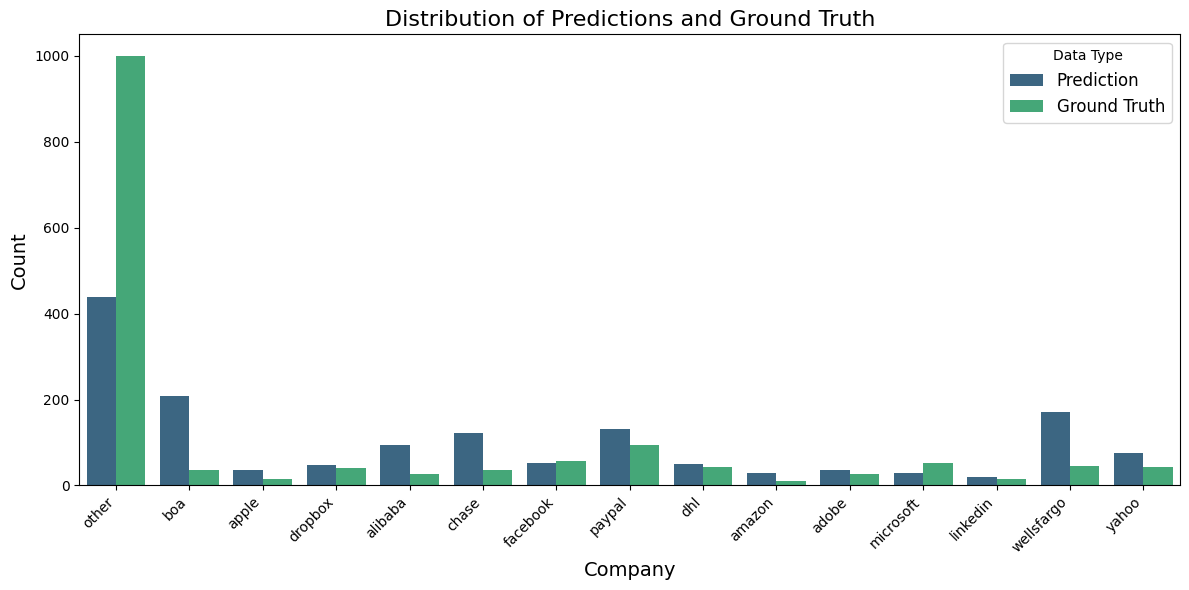

In [8]:
data = visualize(y_true, y_pred)

In [9]:
data[data["Type"] == "Prediction"]["Company"].value_counts()

Company
other         438
boa           209
wellsfargo    170
paypal        131
chase         122
alibaba        95
yahoo          76
facebook       52
dhl            50
dropbox        47
apple          37
adobe          36
amazon         29
microsoft      28
linkedin       19
Name: count, dtype: int64

In [10]:
data[data["Type"] == "Ground Truth"]["Company"].value_counts()

Company
other         1000
paypal          93
facebook        57
microsoft       53
wellsfargo      45
yahoo           44
dhl             42
dropbox         40
chase           37
boa             35
adobe           27
alibaba         26
apple           15
linkedin        14
amazon          11
Name: count, dtype: int64